In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import glob
import random
import re
import subprocess

from tqdm import tqdm

## Patients table

In [2]:
'''
'Crohn disease': K50
'Ulcerative colitis': K51
'Type II diabetes': E11
'Breast cancer (selected using MutPanning26)': C50? Malignant neoplasms of breast
'''

diseases = [
    ('crohn', 'K50'),
    ('ulcerative_colitis', 'K51'),
    ('type_ii_diabetes', 'E11'),
    ('breast_cancer', 'C50')
]

In [3]:
'''
with open('test.csv', 'w') as f:
    cat = subprocess.Popen(["cat", "/home/vasikam/ukb_public_diagnoses.csv"],
                           stdout=subprocess.PIPE)
    hd = subprocess.Popen(["wc"], stdin=cat.stdout, stdout=f)
    
with open("test.txt", "w") as f:
    a = subprocess.Popen(["echo", "e\nsd"], stdout=subprocess.PIPE)
    b = subprocess.Popen(["head", "-c", "2"], stdin=a.stdout, stdout=f)
''' 
''
# for some reason i was unable to get this working, hence the following cell

''

In [4]:
for disease, ICD in diseases:
    output_filename = f'../patients-csvs/{disease}_patients.csv'
    !cat ../ukbiobank_link/tables/ukb_public_diagnoses.csv | head -n 1 > $output_filename
    !cat ../ukbiobank_link/tables/ukb_public_diagnoses.csv | grep $ICD >> $output_filename

cat: write error: Broken pipe
cat: write error: Broken pipe
cat: write error: Broken pipe
cat: write error: Broken pipe


In [5]:
patients_df = {}
for disease, ICD in diseases:
    csv_filename = f'../patients-csvs/{disease}_patients.csv'
    patients_df[disease] = pd.read_csv(csv_filename)
    print(patients_df[disease].head(3))

       eid  diagnosis_number diagnosis              diagnosis_date  \
0  1002586                 8      K500  2015-03-26 00:00:00.000000   
1  1006327                16      K501  2014-06-19 00:00:00.000000   
2  1006327                17      K509  2019-02-17 00:00:00.000000   

  icd_classification  
0              ICD10  
1              ICD10  
2              ICD10  
       eid  diagnosis_number diagnosis              diagnosis_date  \
0  1000871                 6      K513  2010-10-21 00:00:00.000000   
1  1000871                 7      K519  2001-07-31 00:00:00.000000   
2  1001144                 1      K519  2013-09-27 00:00:00.000000   

  icd_classification  
0              ICD10  
1              ICD10  
2              ICD10  
       eid  diagnosis_number diagnosis              diagnosis_date  \
0  1000101                 0      E119  2020-03-18 00:00:00.000000   
1  1000174                 0      E119  2012-04-11 00:00:00.000000   
2  1000193                 1      E119  2005

In [6]:
for disease, ICD in diseases:
    print(disease, np.unique(patients_df[disease]['diagnosis'].values))

crohn ['K500' 'K501' 'K508' 'K509']
ulcerative_colitis ['K510' 'K511' 'K512' 'K513' 'K514' 'K515' 'K518' 'K519']
type_ii_diabetes ['E110' 'E111' 'E112' 'E113' 'E114' 'E115' 'E116' 'E117' 'E118' 'E119']
breast_cancer ['C500' 'C501' 'C502' 'C503' 'C504' 'C505' 'C506' 'C508' 'C509']


In [7]:
disease_eids = {}
for disease, ICD in diseases:
    csv_filename = f'../patients-csvs/{disease}_patients.csv'
    disease_eids[disease] = pd.read_csv(csv_filename)['eid'].values
    print(len(disease_eids[disease]), len(set(disease_eids[disease])))
    
# These results show that eids repeat
# One patients can have several codes from one group (e.g. K500+K508)

4216 2832
7196 5211
45504 38993
20980 17241


In [8]:
disease_eids = {}
vcf_cols = {}
for disease, ICD in diseases:
    csv_filename = f'../patients-csvs/{disease}_patients.csv'
    disease_eids[disease] = set(pd.read_csv(csv_filename)['eid'].values)
    #vcf_cols[disease] = [str(i) + '_' + str(i) for i in disease_eids[disease]]
    #diabetes_eids
    print(disease, len(disease_eids[disease]), list(disease_eids[disease])[:3], sep='\t')

crohn	2832	[2506753, 5513220, 5627913]
ulcerative_colitis	5211	[2621447, 3276807, 3833870]
type_ii_diabetes	38993	[4063233, 5767170, 5898249]
breast_cancer	17241	[1998853, 4456453, 3506187]


## VCFs

In [9]:
chroms = list(range(1, 23)) + ['X', 'XY', 'Y', 'MT']

### playing with stuff

In [10]:
test_ensure_equal_patients = False
if test_ensure_equal_patients:
    patients_for_chr = {}
    for n_chr in chroms:
        vcf_filename = f'../ukbiobank_link/raw_data/ukb22418_c{n_chr}_b0_v2.vcf'
        r = pd.read_csv(
            vcf_filename,
            skiprows=range(6), 
            sep='\t',
            chunksize=1
        )
        patients_for_chr[n_chr] = [s[:len(s)//2] for s in next(r).columns[9:]]
        print(f"appended chr {n_chr} patients")
    
    print([i == patients_for_chr[1] for _, i in patients_for_chr.items()])
    assert [i == patients_for_chr[1] for _, i in patients_for_chr.items()] == [True]*26

### Patients sampling

In [11]:
smallest_vcf_location = "../biobank_extracted/extracted_snps_c6_w500.vcf"

r = pd.read_csv(
    smallest_vcf_location, 
    skiprows=range(6), 
    #usecols=['5825360_5825360', '5467150_5467150'],
    sep='\t',
    chunksize=1
)

In [12]:
one_row = next(r)
first_cols = list(one_row.columns[:9])
one_row

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2821142_2821142,...,5825360_5825360,1846399_1846399,1814390_1814390,5349403_5349403,5944723_5944723,4913903_4913903,3647765_3647765,5467150_5467150,5593902_5593902,2338527_2338527
0,6,30029109,rs7770557,C,G,.,.,PR,GT,0/0,...,0/0,0/0,0/1,0/0,0/1,0/1,0/0,0/1,0/0,0/0


In [13]:
first_cols

['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT']

In [14]:
patients_stat_table = pd.DataFrame(index=(disease for disease, _ in diseases),
                                   columns=['all', 'healthy', 'ill', 'missing in vcf'])

vcf_all_eids = {int(s[:len(s)//2]) for s in one_row.columns[9:]}
healthy_eids = {}
missing_eids = {}
disease_used_eids = {}

for disease, ICD in diseases:
    healthy_eids[disease] = vcf_all_eids - disease_eids[disease]
    missing_eids[disease] = disease_eids[disease] - vcf_all_eids
    disease_used_eids[disease] = disease_eids[disease] - missing_eids[disease]
    
    patients_stat_table['all'][disease] = len(vcf_all_eids)
    patients_stat_table['healthy'][disease] = len(healthy_eids[disease])
    patients_stat_table['ill'][disease] = len(disease_used_eids[disease])
    patients_stat_table['missing in vcf'][disease] = len(missing_eids[disease])  # those that are found in ICD data, but not in genotype data
    
    
#patients_stat_table['sum'] = patients_stat_table['healthy'] + patients_stat_table['ill'] + 0*patients_stat_table['missing in vcf']
patients_stat_table

,all,healthy,ill,missing in vcf
crohn,488377,485647,2730,102
ulcerative_colitis,488377,483310,5067,144
type_ii_diabetes,488377,450775,37602,1391
breast_cancer,488377,471997,16380,861


In [15]:
disease_cols = {}
healthy_cols = {}

for disease, ICD in diseases:
    disease_cols[disease] = [str(x) + '_' + str(x) for x in disease_used_eids[disease]]
    healthy_cols[disease] = [str(x) + '_' + str(x) for x in healthy_eids[disease]]

    print(len(disease_cols[disease]), len(healthy_cols[disease]), disease)

2730 485647 crohn
5067 483310 ulcerative_colitis
37602 450775 type_ii_diabetes
16380 471997 breast_cancer


In [16]:
for trait, ICD in diseases:
    pheno_filename = f'../patients-csvs/{trait}_patients.pheno'
    with open(pheno_filename, 'w') as out_file:
        for healthy_eid in healthy_eids[trait]:
            print(healthy_eid, healthy_eid, "1", sep='\t', file=out_file)
        for disease_eid in disease_used_eids[trait]:
            print(disease_eid, disease_eid, "2", sep='\t', file=out_file)

### Taking SNPs


#### Older try (deleted)


grepping lists of SNP IDs from full vcf files (cMT here):
```
echo $(date) && cat ../ukbiobank_link/raw_data/ukb22418_cMT_b0_v2.vcf | tail -n +7 | grep -o -P "^([^\t]*\t){8}[^\t]*" > biobank_snps_chrMT.vcf && echo $(date)
```



(base) vasikam@Sydney:~$ wc -l ../ukbiobank_link/raw_data/ukb22418_c6_b0_v2.vcf\

53702 ../ukbiobank_link/raw_data/ukb22418_c6_b0_v2.vcf


#### Better try, with the power of PLINK!

SNPs are chosen with `asbs_near_eqtls.py`.


##### SNPs from different size windows

In [17]:
PLINK_EXEC_PATH = "../plink_linux_x86_64_20220402/plink"

In [18]:
window_sizes = [500 * 2**i for i in range(16)]

In [19]:
all_biobank_snps = np.array([])
for ch in chroms:
    #pd.read_csv(f'../biobank_snps_chr{ch}.vcf', sep='\t')
    all_biobank_snps = np.hstack([all_biobank_snps,  pd.read_csv(f'../biobank_grepped_snp_ids/biobank_snps_chr{ch}.vcf', sep='\t')['ID'].values])
all_biobank_snps.shape, all_biobank_snps

((805426,),
 array(['rs28659788', 'rs116587930', 'rs116720794', ..., 'Affx-79443532',
        'Affx-89025709', 'Affx-79381726'], dtype=object))

In [20]:
adastra_snps_count = {trait: {} for trait, _ in diseases}
for trait, _ in diseases:
    for wsize in window_sizes:
        # Do we need _woheaders anymore?
        snp_ids = set()
        
        with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05.txt', 'r') as in_f:
            with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05_woheaders.txt', 'w') as out_f:
                for line in in_f.readlines():
                    if line[:4] != "ASBs":
                        out_f.write(line)
                        snp_ids.add(line.split('\t')[3])
                        
        
        with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05_snp_ids_list.txt', 'w') as out_f:
            for snp_id in snp_ids:
                print(snp_id, file=out_f)
                
        adastra_snps_count[trait][wsize] = len(snp_ids)

In [21]:
biobank_snps_count = {trait: {} for trait, _ in diseases}
for trait, _ in diseases:
    print(trait)
    for wsize in window_sizes:
        exit_codes = {chrom: [] for chrom in chroms}
        present_snp_count = 0
        for chrom in chroms:
            proc = subprocess.run([PLINK_EXEC_PATH, 
                                   "--bfile", f"../ukbiobank/raw_data/ukb22418_c{chrom}_b0_v2", 
                                   "--pheno", f"../patients-csvs/{trait}_patients.pheno",
                                   "--extract", f"asbs_near_eqtls/{trait}/w{wsize}_p0.05_snp_ids_list.txt",
                                   "--allow-no-sex", 
                                   # "--recode", "vcf",  # create vcf
                                   "--make-bed",  # create bed+fam+bim
                                   "--out", f"../biobank_extracted/{trait}/extracted_snps_c{chrom}_w{wsize}"],
                                 capture_output=True)

            # --keep testpatients to get patients
            #print(proc.stdout.decode())
            #print(proc.stderr.decode())
            if proc.stderr.decode().strip() in ['Error: No variants remaining after --extract.', '']:
                pass
            else:
                print(proc.stderr.strip())
                
            #if proc.stderr.decode().strip() == '':
            #    print(proc.stdout.decode())
            
            if 'Error: No variants remaining after --extract.' in proc.stderr.decode():
                pass  # present_snp_count += 0
            elif (match := re.search("--extract:.\D*(\d+) variant", proc.stdout.decode())) is not None:
                present_snp_count += int(match.group(1))
            else:
                print(proc.stderr)
            
            if proc.returncode != 0:  # 12: No variants remaining after --extract??
                #print(f"PLINK returned exit code {proc.returncode} for c{chrom} and wsize={wsize}")
                pass
            else:
                #print(f"PLINK returned 0 for c{chrom} and wsize={wsize}")
                pass
            
            exit_codes[chrom] = proc.returncode
        print(f"{present_snp_count} variants found in biobank for trait {trait} and window size {wsize}")
        biobank_snps_count[trait][wsize] = present_snp_count
        #print(f"Exit codes for window size {wsize}:")
        #print(exit_codes)
print(biobank_snps_count)

crohn
0 variants found in biobank for trait crohn and window size 500
0 variants found in biobank for trait crohn and window size 1000
0 variants found in biobank for trait crohn and window size 2000
0 variants found in biobank for trait crohn and window size 4000
0 variants found in biobank for trait crohn and window size 8000
0 variants found in biobank for trait crohn and window size 16000
0 variants found in biobank for trait crohn and window size 32000
0 variants found in biobank for trait crohn and window size 64000
0 variants found in biobank for trait crohn and window size 128000
0 variants found in biobank for trait crohn and window size 256000
0 variants found in biobank for trait crohn and window size 512000
0 variants found in biobank for trait crohn and window size 1024000
0 variants found in biobank for trait crohn and window size 2048000
0 variants found in biobank for trait crohn and window size 4096000
0 variants found in biobank for trait crohn and window size 8192000

In [22]:
for trait, _ in diseases:
    print(f"Merging {trait}")
    for wsize in tqdm(window_sizes, ncols=80):
        prefix_merge_list = [s[:-4] for s in glob.glob(f"../biobank_extracted/{trait}/extracted_snps_c*_w{wsize}*.bed")]
        if len(prefix_merge_list) == 0:
            continue
        
        merge_list_filename = "mergelist_tmp" 
        with open(merge_list_filename, "w") as f:
            print(*prefix_merge_list, sep='\n', file=f)
        proc = subprocess.run([PLINK_EXEC_PATH, 
                               "--merge-list", merge_list_filename,
                               "--out", f"../biobank_extracted/{trait}/extracted_snps_merged_w{wsize}"],
                             capture_output=True)

        

Merging crohn


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 504.04it/s]


Merging ulcerative_colitis


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 562.27it/s]


Merging type_ii_diabetes


100%|███████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Merging breast_cancer


100%|███████████████████████████████████████████| 16/16 [01:00<00:00,  3.78s/it]


In [23]:
#wsize = 64000

for trait, _ in diseases:
    print(trait)
    print("wsize adastra biobank")
    for wsize in window_sizes:
        print(f"{wsize:<8} {adastra_snps_count[trait][wsize]:<5} {biobank_snps_count[trait][wsize]}")

crohn
wsize adastra biobank
500      0     0
1000     0     0
2000     0     0
4000     0     0
8000     0     0
16000    0     0
32000    0     0
64000    0     0
128000   1     0
256000   1     0
512000   2     0
1024000  2     0
2048000  2     0
4096000  2     0
8192000  7     0
16384000 7     0
ulcerative_colitis
wsize adastra biobank
500      0     0
1000     0     0
2000     0     0
4000     0     0
8000     0     0
16000    0     0
32000    0     0
64000    0     0
128000   0     0
256000   0     0
512000   0     0
1024000  0     0
2048000  0     0
4096000  0     0
8192000  3     0
16384000 3     0
type_ii_diabetes
wsize adastra biobank
500      7     0
1000     9     0
2000     10    0
4000     10    0
8000     10    0
16000    10    0
32000    13    0
64000    15    0
128000   20    1
256000   26    2
512000   34    3
1024000  69    7
2048000  119   10
4096000  198   13
8192000  290   22
16384000 442   36
breast_cancer
wsize adastra biobank
500      178   15
1000     193   17


In [ ]:
#wsize = 64000

for trait, _ in diseases:
    print(trait)
    variants_dfs_allpatients = {wsize: pd.DataFrame() for wsize in window_sizes}
    for wsize in window_sizes:
        for filename in glob.glob(f'../biobank_extracted/{trait}/extracted_snps_c*_w{wsize}.vcf'):
            df = pd.read_csv(
                filename,
                skiprows=range(6),
                sep='\t',
                #usecols=first_cols + healthy_cols + diabetes_cols,
                dtype={'ID': str},
            )
            #print(df)
            variants_dfs_allpatients[wsize] = pd.concat([variants_dfs_allpatients[wsize], df], ignore_index=True)


        print(wsize, variants_dfs_allpatients[wsize].shape)

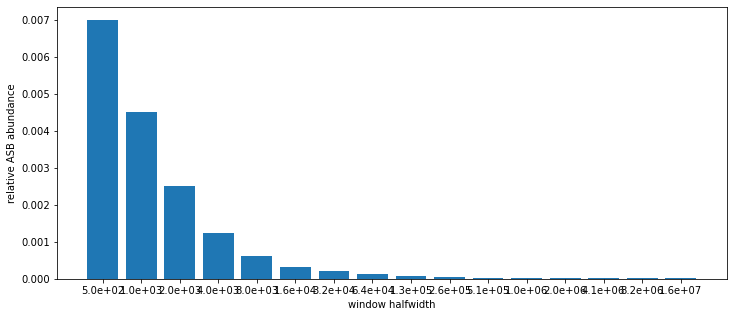

In [24]:
fig = plt.figure(figsize=(12, 5))
rel_counts = [adastra_snps_count["type_ii_diabetes"][wsize] / (2 * wsize) for wsize in window_sizes]
plt.bar([f'{wsize:.1e}' for wsize in window_sizes], rel_counts)
plt.xlabel('window halfwidth')
plt.ylabel('relative ASB abundance')
plt.show()

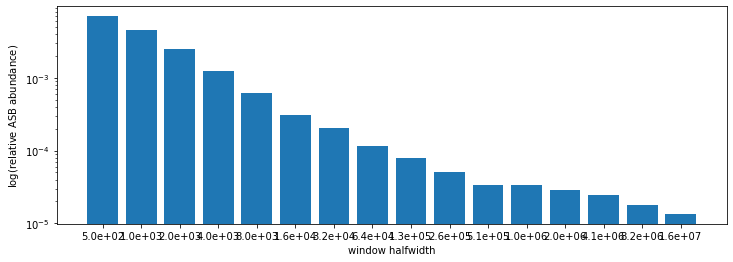

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
#fig, ax = plt.subplots(1, 1, figsize=(36, 15))
rel_counts = [adastra_snps_count["type_ii_diabetes"][wsize] / (2 * wsize) for wsize in window_sizes]
plt.bar([f'{wsize:.1e}' for wsize in window_sizes], rel_counts)
plt.xlabel('window halfwidth')
plt.ylabel('$\log($relative ASB abundance$)$')
ax.set_yscale(matplotlib.scale.LogScale(ax))
plt.savefig('rel_ASB_abund.png')

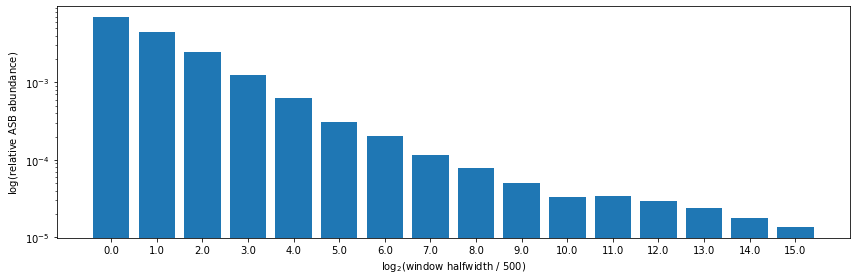

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
#fig, ax = plt.subplots(1, 1, figsize=(36, 15))
rel_counts = [adastra_snps_count["type_ii_diabetes"][wsize] / (2 * wsize) for wsize in window_sizes]
plt.bar([f'{i:.1f}' for i in range(len(window_sizes))], rel_counts)
plt.xlabel('$\log_2$(window halfwidth / 500)')
plt.ylabel('$\log($relative ASB abundance$)$')
ax.set_yscale(matplotlib.scale.LogScale(ax))
plt.tight_layout()
plt.savefig('rel_ASB_abund.png')

## Logistic Regression

### sklearn regressions

In [39]:
#import sklearn

In [22]:
from sklearn.linear_model import LogisticRegression  #other?
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [20]:
Xs = {}
for wsize, df in variants_dfs.items():
    #print(wsize)
    #pass
    Xs[wsize] = variants_dfs[wsize].set_index(variants_dfs[wsize]['ID'].values).drop(columns=first_cols).T
    Xs[wsize] = pd.get_dummies(Xs[wsize])

In [24]:
Xs[2000]

,rs7770557_./.,rs7770557_0/0,rs7770557_0/1,rs7770557_1/1
2658515_2658515,0,1,0,0
5418788_5418788,0,1,0,0
1410704_1410704,0,1,0,0
5678089_5678089,0,1,0,0
1863781_1863781,0,1,0,0
...,...,...,...,...
2631746_2631746,0,1,0,0
3331715_3331715,0,1,0,0
1874054_1874054,0,1,0,0
5028626_5028626,0,1,0,0


In [27]:
RocCurveDisplay.from_predictions

<bound method RocCurveDisplay.from_predictions of <class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>>

In [82]:
wsize=2048000  #16384000 #8192000 

logreg = LogisticRegression(max_iter=250)

X = Xs[wsize]
y = [int(i in diabetes_cols) for i in X.index.values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:, 1]
rocauc = roc_auc_score(y_test, y_pred)
print(f"w{wsize}: rocauc = {rocauc:.4f}")

w2048000: rocauc = 0.5216


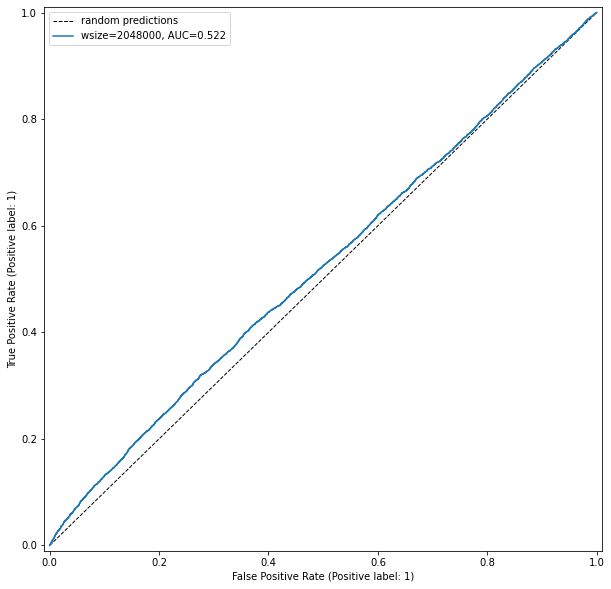

In [83]:
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.plot([0, 1], [0, 1], ls='--', lw=1, c='k')

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.legend(['random predictions', f'wsize={wsize}, AUC={rocauc:.3f}'])

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.savefig('roc_curve_example.png')

KeyboardInterrupt: 

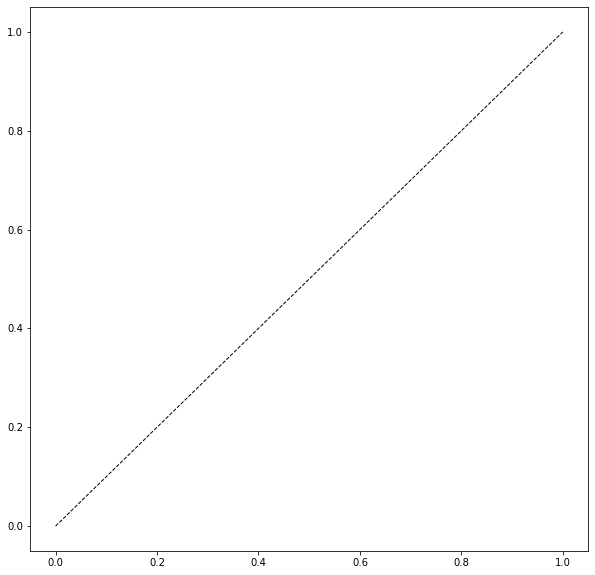

In [21]:
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.plot([0, 1], [0, 1], ls='--', lw=1, c='k')

rocaucs = []
for wsize in window_sizes:
    logreg = LogisticRegression(max_iter=250)
    
    X = Xs[wsize]
    y = [int(i in diabetes_cols) for i in X.index.values]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    logreg.fit(X_train, y_train)
    rocauc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
    rocaucs.append(rocauc)
    print(f"w{wsize}: rocauc = {rocauc:.4f}")
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax)
legend = ['random predictions'] + [f'wsize={wsize}, AUC={rocauc:.3f}' for wsize, rocauc in zip(window_sizes, rocaucs)]
ax.legend(legend)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.show()

In [28]:
np.mean([3])

3.0

In [69]:
rocaucs = {}
n_regressions = 5
for wsize in window_sizes:
    rocaucs[wsize] = []
    for _ in range(n_regressions):
        healthy_used_eids = random.sample(list(healthy_eids), len(diabetes_used_eids))
        healthy_cols = [str(x) + '_' + str(x) for x in healthy_used_eids]
        
        
        
        variants_df = variants_dfs_allpatients[wsize][first_cols + healthy_cols + diabetes_cols]
            
        X = variants_dfs[wsize].set_index(variants_dfs[wsize]['ID'].values).drop(columns=first_cols).T
        X = pd.get_dummies(Xs[wsize])
        y = [int(i in diabetes_cols) for i in X.index.values]
    
        
        


        logreg = LogisticRegression(max_iter=500)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        logreg.fit(X_train, y_train)
        rocauc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
        rocaucs[wsize].append(rocauc)
        
        print('.', end='')
        
    print()
    print(f"w{wsize}: rocauc = {np.mean(rocaucs[wsize]):.4f} +- {np.std(rocaucs[wsize], ddof=1):.4f}")

.........................
w500: rocauc = 0.5087 +- 0.0022
.........................
w1000: rocauc = 0.5077 +- 0.0020
.........................
w2000: rocauc = 0.5082 +- 0.0025
.........................
w4000: rocauc = 0.5082 +- 0.0020
.........................
w8000: rocauc = 0.5080 +- 0.0026
.........................
w16000: rocauc = 0.5075 +- 0.0021
.........................
w32000: rocauc = 0.5078 +- 0.0022
.........................
w64000: rocauc = 0.5123 +- 0.0040
.........................
w128000: rocauc = 0.5218 +- 0.0029
.........................
w256000: rocauc = 0.5235 +- 0.0028
.........................
w512000: rocauc = 0.5226 +- 0.0037
.........................
w1024000: rocauc = 0.5252 +- 0.0035
.........................
w2048000: rocauc = 0.5255 +- 0.0041
.........................
w4096000: rocauc = 0.5272 +- 0.0042
.........................
w8192000: rocauc = 0.5411 +- 0.0036
.........................
w16384000: rocauc = 0.5452 +- 0.0038


In [76]:
means = [np.mean(i) for _, i in rocaucs.items()]
stds = [np.std(i, ddof=1) for _, i in rocaucs.items()]
means, stds

([0.5086560273976479,
  0.5077065536174478,
  0.5082368127540908,
  0.5082326428064842,
  0.5080232471291989,
  0.507465457578282,
  0.5078301668305234,
  0.51233389683853,
  0.5218336028182177,
  0.5235164247155264,
  0.5226079840935928,
  0.5251798560499024,
  0.5254556303794695,
  0.5271545225438617,
  0.5411215815614677,
  0.5451738330657725],
 [0.0022265043049717664,
  0.0019868608208275015,
  0.0024602808987920044,
  0.001987899112990431,
  0.0025849958467311796,
  0.0020995765729978294,
  0.002180527276660362,
  0.004033830451106213,
  0.002886557970462429,
  0.002814197535000761,
  0.0036788999650365682,
  0.003451131473002269,
  0.0040840740041853405,
  0.004234564811232111,
  0.003582819134258206,
  0.0038089404464142175])

In [70]:
rocaucs

{500: [0.51024448450299,
  0.5083827497428003,
  0.5059980634824423,
  0.5084643764018707,
  0.506666739853379,
  0.5098455053398403,
  0.5087760626086522,
  0.5121666279275827,
  0.5087246244523748,
  0.5071872867137134,
  0.5094054903009857,
  0.5077962751250676,
  0.5120795324503737,
  0.5065803919667511,
  0.5079497810761531,
  0.5059549772524987,
  0.5088640090799262,
  0.5058599747172267,
  0.5083789727676395,
  0.5116260599298021,
  0.5137800272515425,
  0.5074297394446836,
  0.5076678063951071,
  0.5113277962225417,
  0.5052433299352518],
 1000: [0.5074042321278873,
  0.5094853229689623,
  0.5064281192669479,
  0.5066247793720533,
  0.5105736754375585,
  0.5056426350062002,
  0.5073366021906788,
  0.5075164108961859,
  0.5123585866806637,
  0.5074279394615108,
  0.5085421419389439,
  0.5090232771294224,
  0.5043667595006811,
  0.5096071804349028,
  0.5037990219685722,
  0.5094520287019738,
  0.5090855519476882,
  0.5073003537447606,
  0.5057096432480298,
  0.5068233148499197,
 

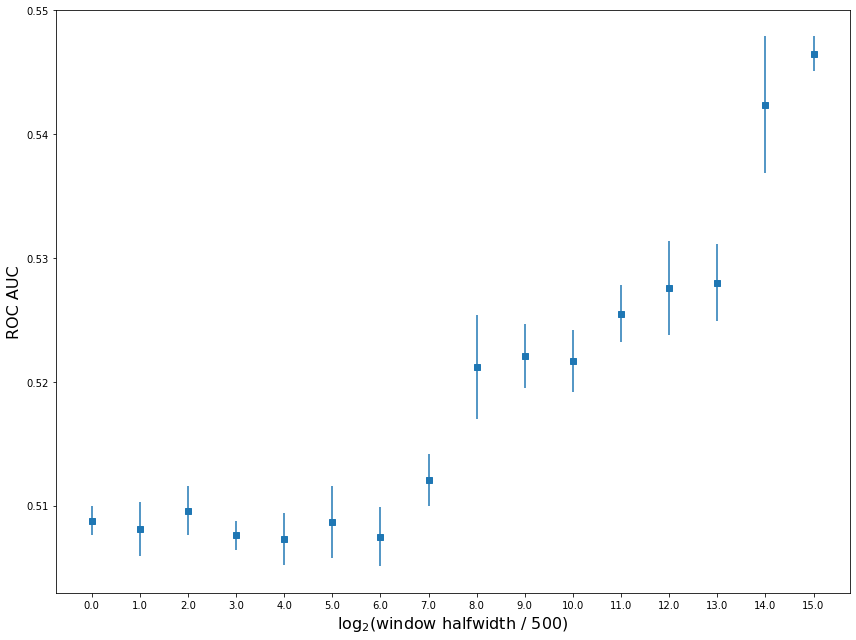

In [67]:
s = '''w500: rocauc = 0.5088 +- 0.0012
w1000: rocauc = 0.5081 +- 0.0022
w2000: rocauc = 0.5096 +- 0.0020
w4000: rocauc = 0.5076 +- 0.0012
w8000: rocauc = 0.5073 +- 0.0021
w16000: rocauc = 0.5087 +- 0.0029
w32000: rocauc = 0.5075 +- 0.0024
w64000: rocauc = 0.5121 +- 0.0021
w128000: rocauc = 0.5212 +- 0.0042
w256000: rocauc = 0.5221 +- 0.0026
w512000: rocauc = 0.5217 +- 0.0025
w1024000: rocauc = 0.5255 +- 0.0023
w2048000: rocauc = 0.5276 +- 0.0038
w4096000: rocauc = 0.5280 +- 0.0031
w8192000: rocauc = 0.5424 +- 0.0055
w16384000: rocauc = 0.5465 +- 0.0014'''.split('\n')
s = np.array([[float(i.split()[-3]), float(i.split()[-1])] for i in s])
s
plt.figure(figsize=(12, 9))
plt.errorbar([f'{i:.1f}' for i in range(16)], s[:, 0], yerr=s[:, 1], ls='', fmt='s')
plt.xlabel('$\log_2$(window halfwidth / 500)', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.tight_layout()
plt.savefig('rocaucs.png')


In [ ]:
wsizes = [500 * 2**i for i in range(16)]
vals = {ws: auc for ws, auc in zip(wsizes, [0.]*16) }

for i in range(8):
    print(f"{wsizes[i]} & {vals[wsizes[i]]} & {wsizes[i+8]} & {vals[wsizes[i+8]]} \\\\\\hline")


In [197]:
assert (np.unique(variants_df_T.values) == ['./.', '0/0', '0/1', '1/1']).all()
np.unique(variants_df_T.values)

array(['./.', '0/0', '0/1', '1/1'], dtype=object)

In [198]:
np.sum(variants_df_T.values == './.')

488

In [174]:
# takes around 30-40 secs
y = [int(i in diabetes_cols) for i in variants_df_T.index.values]
print(len(y), '\n', *y[:30])

75204 
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0


In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [202]:
X_train

,rs7770557_./.,rs7770557_0/0,rs7770557_0/1,rs7770557_1/1,rs115321330_./.,rs115321330_0/0,rs115321330_0/1,rs115321330_1/1,rs1893250_./.,rs1893250_0/0,rs1893250_0/1,rs1893250_1/1
5864019_5864019,0,1,0,0,0,1,0,0,0,1,0,0
3282140_3282140,0,1,0,0,0,1,0,0,0,0,1,0
2154334_2154334,0,1,0,0,0,1,0,0,0,0,1,0
5656831_5656831,0,1,0,0,0,1,0,0,0,0,1,0
5590596_5590596,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2861188_2861188,0,1,0,0,0,1,0,0,0,0,0,1
1039848_1039848,0,1,0,0,0,1,0,0,0,0,1,0
5042100_5042100,0,1,0,0,0,1,0,0,0,0,1,0
3249305_3249305,0,1,0,0,0,1,0,0,0,0,1,0


In [203]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [210]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

0.5158977976373893

In [207]:
logreg.predict_proba(X_test).shape

(18801, 2)

### sklearn redone

In [23]:
from sklearn.linear_model import LogisticRegression  #other?
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [24]:
for trait, _ in diseases:
    print(trait)
    
    n_halfpeople = min(len(healthy_eids[trait]), len(disease_used_eids[trait]))
    
            proc = subprocess.run([PLINK_EXEC_PATH, 
                                   "--bfile", f"../ukbiobank/raw_data/ukb22418_c{chrom}_b0_v2", 
                                   "--pheno", f"../patients-csvs/{trait}_patients.pheno",
                                   "--extract", f"asbs_near_eqtls/{trait}/w{wsize}_p0.05_snp_ids_list.txt",
                                   "--allow-no-sex", 
                                   "--recode", "vcf", 
                                   "--out", f"../biobank_extracted/tmp"],
                                 capture_output=True)

crohn
ulcerative_colitis
type_ii_diabetes
breast_cancer


In [25]:
def foo(*args):
    print(*args)

In [27]:
foo(2, 4, [3,4], *[3,4], [3,4], *[3,4])

2 4 [3, 4] 3 4 [3, 4] 3 4


### PLINK regressions

?????